# Section 0: Import necessary libraries

In [2]:
# Load all imports

import os, random, copy
from pathlib import Path
from PIL import Image
import numpy as np
import numpy.typing as npt
import pandas as pd
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from coral_dataset import CoralDataset
import torch.nn as nn
import segmentation_models_pytorch as smp
from tqdm import tqdm
import warnings
from typing import Any, Tuple, Union
import cv2
import matplotlib.pyplot as plt

import os, cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern
from tqdm import tqdm
from skimage.feature import graycomatrix, graycoprops
from sklearn.preprocessing import StandardScaler

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

import numpy as np
import pandas as pd
from numpy.linalg import inv

c:\Users\timow\Documents\School\GitHub\DC3 clean\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Section 1: Preprocessing

### 1.1 Prepare the bleaching dataset

Originally, the bleaching dataset only has bleached and non-bleached masks. 
The union of these two masks is saved to represent a coral mask.

In [9]:
# Define the directories
root_dir = Path("data/coral_bleaching")
images_dir = root_dir / "images"
bleached_dir = root_dir / "masks_bleached"
non_bleached_dir = root_dir / "masks_non_bleached"
out_dir = root_dir / "masks_coral"
out_dir.mkdir(parents=True, exist_ok=True)

def load_mask(mask_path, target_size):
    """Load a mask in L-mode, resize to target_size with NEAREST if needed, return uint8 array."""
    m = Image.open(mask_path).convert("L")
    if (m.height, m.width) != (target_size[0], target_size[1]):
        m = m.resize((target_size[0], target_size[1]), resample=Image.NEAREST)
    mask_array = np.array(m, dtype=np.uint8)
    return ((mask_array > 0)*255).astype(np.uint8)

# Loop over all images, and create the coral masks
created = fails = 0
for img_path in sorted(images_dir.glob("*.jpg")):
    stem = img_path.stem
    bleached_path = bleached_dir / f"{stem}_bleached.png"
    non_bleached_path = non_bleached_dir / f"{stem}_non_bleached.png"

    # Define the image heights and width
    with Image.open(img_path) as image:
        img_H , img_W = image.height, image.width

    # Create the masks
    mask_bleached = load_mask(bleached_path, (img_H, img_W))
    mask_non_bleached = load_mask(non_bleached_path, (img_H, img_W))
    mask_coral = (mask_bleached | mask_non_bleached).astype(np.uint8)

    # Save new masks in new directory
    output_path = out_dir / f"{stem}.png"
    Image.fromarray((mask_coral).astype(np.uint8)).save(output_path)

The bleaching dataset and new coral mask is saved into a DataFrame.  
Any images with less than 1% coral coverage are removed.

In [37]:
# Define the directories
root_dir = Path("data/coral_bleaching")
images_dir = root_dir / "images"
bleached_dir = root_dir / "masks_bleached"
coral_dir = root_dir / "masks_coral"

rows = []

# Loop over all images
for img_path in sorted(images_dir.glob("*.jpg")):
    stem = img_path.stem
    
    # Define the path of the image and mask
    paths = {
        "image": img_path,
        "bleached_coral": bleached_dir / f"{stem}_bleached.png", 
        "mask_coral": coral_dir / f"{stem}.png",
    }
    
    # Load mask and compute coral coverage
    array = np.array(Image.open(paths["mask_coral"]).convert("L")).astype(np.uint8) / 255
    coral_mask_H, coral_mask_W = array.shape
    coral_coverage = array.sum() / (coral_mask_H * coral_mask_W)

    # Save image and mask in DataFrame if coverage is more than 1%
    if coral_coverage >= 0.01:
        rows.append({
        "stem": stem,
        "image_path": str(paths["image"]),
        "bleached_coral_path": str(paths["bleached_coral"]) if paths["mask_coral"].exists() else None,
        "mask_coral_path": str(paths["mask_coral"]) if paths["mask_coral"].exists() else None,
        "coral_coverage": round(float(coral_coverage), 3),
        "source": "coral_bleaching_reefsupport", 
    })

df_clean = pd.DataFrame(rows)

### 1.2 Prepare the benthic dataset

The benthic dataset has masks for hard and soft corals. We create a new mask with the union of these two to represent a general coral mask.  
Any images with less than 1% coral coverage are removed, and the results are appended to the previous DataFrame.

In [38]:
root_dir = Path("data/benthic_datasets")

# Loop over all coral sites and define directories
for site in sorted(os.listdir(root_dir)):
    images_dir = root_dir / site / "images"
    coral_stitched_dir = root_dir / site / "masks_stitched"
    coral_dir = root_dir / site / "masks_coral"
    coral_dir.mkdir(parents=True, exist_ok=True)
    rows = []

    # Loop over all images per site
    for img_path in sorted(images_dir.glob("*.[jJ][pP][gG]")):
        stem = img_path.stem
        
        # Save all paths
        paths = {
            "image": img_path,
            "coral_stitched_dir": coral_stitched_dir / f"{stem}_mask.png",
            "mask_coral": coral_dir / f"{stem}_binary.png",
        }

        # Convert rgb array to coral-only binary array and save the new array
        with Image.open(paths["coral_stitched_dir"]) as mm:
            rgb_array = np.array(mm.convert("RGB"))
            binary_array = (rgb_array.any(axis=-1)).astype(np.uint8) * 255
        out_path = coral_dir / f"{stem}_binary.png"
        Image.fromarray(binary_array).save(out_path)

        # Compute the coral coverage, exclude any images with <0.01 coverage, and add the others to the dataframe
        coral_mask_H, coral_mask_W = binary_array.shape
        coral_coverage = (binary_array/255).sum() / (coral_mask_H * coral_mask_W)
        if coral_coverage >= 0.01:
            rows.append({
            "stem": stem,
            "image_path": str(paths["image"]),
            "mask_coral_path": str(paths["mask_coral"]) if paths["mask_coral"].exists() else None,
            "coral_coverage": round(float(coral_coverage), 3),
            "source": str(site), 
        })

    df_clean = pd.concat([df_clean, pd.DataFrame(rows)], ignore_index=True).reset_index(drop=True)

### 1.3 Train/test/val split

A train/test/val split of 70/15/15 is good practice.  
To ensure domain robustness across reef locations, images from one source should not be in multiple splits.  
To achieve this, the images from sources are divided among the splits.  
The division that was used achieves a 72/13/15 split, which is quite good.

In [39]:
# Show the number of images per source
for source in np.unique(df_clean["source"]):
    print(f"{source}: {len(df_clean[df_clean["source"] == source])}")
print()

# Create a custom division of the sources over the 3 splits.
train_sources = ["SEAFLOWER_BOLIVAR", "SEAVIEW_ATL", "SEAVIEW_PAC_AUS", "UNAL_BLEACHING_TAYRONA", "coral_bleaching_reefsupport"]
test_sources = ["SEAFLOWER_COURTOWN", "SEAVIEW_PAC_USA"]
val_sources = ["SEAVIEW_IDN_PHL", "TETES_PROVIDENCIA"]

df_clean["split"] = df_clean["source"].apply(
    lambda s: "train" if s in train_sources else
              "test" if s in test_sources else
              "val" if s in val_sources else None
)

# Save the csv file
Path("csv_folder/").mkdir(parents=True, exist_ok=True)
df_clean.to_csv("csv_folder/df_clean.csv", index=False)

# Show train/test/val ratios
split_counts = df_clean["split"].value_counts().sort_index()
split_perc = (split_counts / len(df_clean) * 100).round(1)

for split in ["train", "val", "test"]:
    count = split_counts.get(split, 0)
    perc = split_perc.get(split, 0)
    print(f"  {split:<6}: {count:>4} images ({perc:>4.1f}%)")

SEAFLOWER_BOLIVAR: 245
SEAFLOWER_COURTOWN: 211
SEAVIEW_ATL: 640
SEAVIEW_IDN_PHL: 446
SEAVIEW_PAC_AUS: 633
SEAVIEW_PAC_USA: 269
TETES_PROVIDENCIA: 105
UNAL_BLEACHING_TAYRONA: 602
coral_bleaching_reefsupport: 601

  train : 2721 images (72.5%)
  val   :  551 images (14.7%)
  test  :  480 images (12.8%)


### 1.4 Resize the images and masks

After some testing, we decided to resize all images and masks to 512x512.  
This seemed like a good balance between not affecting model accuracy and maintaining an affordable computation effort. 

In [40]:
import cv2
import pandas as pd
from pathlib import Path
from tqdm import tqdm

output_dir = Path("data/final_dataset")
output_dir.mkdir(parents=True, exist_ok=True)
img_size = (512,512)
rows_out = []

for _, row in tqdm(df_clean.iterrows(), total=len(df_clean)):
    # Define variables per row
    stem = row["stem"]
    img_path = Path(row["image_path"])
    mask_path = Path(row["mask_coral_path"])
    source = row["source"]
    split = row["split"]

    # Define directories and paths
    out_img_dir  = output_dir / split / "images"
    out_mask_dir = output_dir / split / "masks_coral"
    out_img_dir.mkdir(parents=True, exist_ok=True)
    out_mask_dir.mkdir(parents=True, exist_ok=True)
    out_img_path  = out_img_dir / f"{stem}.jpg"
    out_mask_path = out_mask_dir / f"{stem}.png"

    # Read image and mask
    img = cv2.imread(str(img_path), cv2.IMREAD_COLOR)
    mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)

    # Resize image and mask to 512x512
    img_resized  = cv2.resize(img, img_size, interpolation=cv2.INTER_CUBIC)
    mask_resized = cv2.resize(mask, img_size, interpolation=cv2.INTER_NEAREST)

    # Save resized images and masks
    cv2.imwrite(str(out_img_path), img_resized, [cv2.IMWRITE_JPEG_QUALITY, 95])
    cv2.imwrite(str(out_mask_path), mask_resized)

    # Create new row for dataframe
    rows_out.append({
        "stem": stem,
        "image_path": str(out_img_path),
        "mask_coral_path": str(out_mask_path),
        "source": source,
        "split": split,
    })

df_resized = pd.DataFrame(rows_out).reset_index(drop=True)
df_resized.to_csv("csv_folder/resized_df.csv", index=False)

100%|██████████| 3752/3752 [03:31<00:00, 17.75it/s]


# Section 2: Model

### Section 2.0 Load the DataFrame

The code from section 1 can be run to see if it works. It should take around 20 minutes.  
Alternatively, you can also load the DataFrame by running the cell below. 

In [41]:
df_resized = pd.read_csv("csv_folder/resized_df.csv")

### 2.1 Load data splits and define augmentation

Separate DataFrames are made for training and validation.  
Image transformation are defined. For this we resize to 256x256, perform random flips, do normalization, and convert to PyTorch tensors.  
Finally we warp the data in Dataset objects, and build dataloaders.

In [ ]:
# Set seed for reproducability  GOOD code
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# Create training and validation dataframes
df_train = df_resized[df_resized["split"] == "train"].reset_index(drop=True)
df_val = df_resized[df_resized["split"] == "val"].reset_index(drop=True)
print(f"📊 Train: {len(df_train)} | Val: {len(df_val)}")

# Define augmentations
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)
train_transform = A.Compose([
    A.LongestMaxSize(max_size=512, interpolation=cv2.INTER_LINEAR),
    A.PadIfNeeded(min_height=512, min_width=512, border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.LongestMaxSize(max_size=512, interpolation=cv2.INTER_LINEAR),
    A.PadIfNeeded(min_height=512, min_width=512, border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0),
    A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ToTensorV2(),
])


# Create data loaders
use_cuda = torch.cuda.is_available()
num_workers = 8 if use_cuda else 0

train_loader = DataLoader(
    CoralDataset(df_train, transform=train_transform),
    batch_size=4, shuffle=True,
    num_workers=num_workers, persistent_workers=(num_workers > 0),
    pin_memory=use_cuda,
)
val_loader = DataLoader(
    CoralDataset(df_val, transform=val_transform),
    batch_size=4, shuffle=False,
    num_workers=num_workers, persistent_workers=(num_workers > 0),
    pin_memory=use_cuda,
)

📊 Train: 2721 | Val: 551


C:\Users\timow\AppData\Local\Temp\ipykernel_16180\4050466238.py:30: UserWarning: Argument(s) 'value, mask_value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=512, min_width=512, border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0),
C:\Users\timow\AppData\Local\Temp\ipykernel_16180\4050466238.py:40: UserWarning: Argument(s) 'value, mask_value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=512, min_width=512, border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0),


✅ Dataloader OK — imgs torch.Size([4, 3, 512, 512]), masks torch.Size([4, 1, 512, 512])
Using device: cuda


Epoch 1/50 - Train:   0%|          | 0/681 [00:00<?, ?it/s]C:\Users\timow\AppData\Local\Temp\ipykernel_16180\4050466238.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
Epoch 1/50 - Val: 100%|██████████| 138/138 [00:23<00:00,  5.84it/s]



Epoch 1/50
 Train Loss: 0.4164 | IoU: 0.5159 | Acc: 0.8106
 Val   Loss: 0.4332 | IoU: 0.5425 | Acc: 0.8133
  ✅ Saved new best model with IoU=0.5425


Epoch 2/50 - Val: 100%|██████████| 138/138 [00:04<00:00, 28.41it/s]



Epoch 2/50
 Train Loss: 0.3324 | IoU: 0.6048 | Acc: 0.8577
 Val   Loss: 0.4324 | IoU: 0.5509 | Acc: 0.8196
  ✅ Saved new best model with IoU=0.5509


Epoch 3/50 - Val: 100%|██████████| 138/138 [00:04<00:00, 28.15it/s]



Epoch 3/50
 Train Loss: 0.2966 | IoU: 0.6406 | Acc: 0.8763
 Val   Loss: 0.3881 | IoU: 0.5843 | Acc: 0.8315
  ✅ Saved new best model with IoU=0.5843


Epoch 4/50 - Val: 100%|██████████| 138/138 [00:04<00:00, 30.30it/s]



Epoch 4/50
 Train Loss: 0.2735 | IoU: 0.6665 | Acc: 0.8863
 Val   Loss: 0.3610 | IoU: 0.6073 | Acc: 0.8388
  ✅ Saved new best model with IoU=0.6073


Epoch 5/50 - Val: 100%|██████████| 138/138 [00:04<00:00, 31.30it/s]



Epoch 5/50
 Train Loss: 0.2580 | IoU: 0.6816 | Acc: 0.8933
 Val   Loss: 0.3712 | IoU: 0.6059 | Acc: 0.8414


Epoch 6/50 - Val: 100%|██████████| 138/138 [00:04<00:00, 29.88it/s]



Epoch 6/50
 Train Loss: 0.2405 | IoU: 0.7002 | Acc: 0.9005
 Val   Loss: 0.3486 | IoU: 0.6064 | Acc: 0.8476


Epoch 7/50 - Val: 100%|██████████| 138/138 [00:04<00:00, 27.75it/s]



Epoch 7/50
 Train Loss: 0.2280 | IoU: 0.7134 | Acc: 0.9063
 Val   Loss: 0.3647 | IoU: 0.6179 | Acc: 0.8397
  ✅ Saved new best model with IoU=0.6179


Epoch 8/50 - Val: 100%|██████████| 138/138 [00:04<00:00, 28.68it/s]



Epoch 8/50
 Train Loss: 0.2161 | IoU: 0.7278 | Acc: 0.9116
 Val   Loss: 0.3421 | IoU: 0.6322 | Acc: 0.8476
  ✅ Saved new best model with IoU=0.6322


Epoch 9/50 - Val: 100%|██████████| 138/138 [00:04<00:00, 28.66it/s]



Epoch 9/50
 Train Loss: 0.2087 | IoU: 0.7361 | Acc: 0.9142
 Val   Loss: 0.3402 | IoU: 0.6274 | Acc: 0.8497


Epoch 10/50 - Val: 100%|██████████| 138/138 [00:04<00:00, 30.08it/s]



Epoch 10/50
 Train Loss: 0.2053 | IoU: 0.7400 | Acc: 0.9160
 Val   Loss: 0.3509 | IoU: 0.6232 | Acc: 0.8496


Epoch 11/50 - Val: 100%|██████████| 138/138 [00:04<00:00, 29.33it/s]



Epoch 11/50
 Train Loss: 0.2035 | IoU: 0.7413 | Acc: 0.9173
 Val   Loss: 0.3308 | IoU: 0.6382 | Acc: 0.8562
  ✅ Saved new best model with IoU=0.6382


Epoch 12/50 - Val: 100%|██████████| 138/138 [00:04<00:00, 29.34it/s]



Epoch 12/50
 Train Loss: 0.1935 | IoU: 0.7524 | Acc: 0.9215
 Val   Loss: 0.3394 | IoU: 0.6221 | Acc: 0.8488


Epoch 13/50 - Val: 100%|██████████| 138/138 [00:04<00:00, 28.95it/s]



Epoch 13/50
 Train Loss: 0.1906 | IoU: 0.7567 | Acc: 0.9223
 Val   Loss: 0.3177 | IoU: 0.6506 | Acc: 0.8563
  ✅ Saved new best model with IoU=0.6506


Epoch 14/50 - Val: 100%|██████████| 138/138 [00:04<00:00, 30.62it/s]



Epoch 14/50
 Train Loss: 0.1824 | IoU: 0.7663 | Acc: 0.9256
 Val   Loss: 0.3523 | IoU: 0.6383 | Acc: 0.8478


Epoch 15/50 - Val: 100%|██████████| 138/138 [00:04<00:00, 28.71it/s]



Epoch 15/50
 Train Loss: 0.1787 | IoU: 0.7696 | Acc: 0.9276
 Val   Loss: 0.3403 | IoU: 0.6399 | Acc: 0.8515


Epoch 16/50 - Val: 100%|██████████| 138/138 [00:05<00:00, 26.77it/s]



Epoch 16/50
 Train Loss: 0.1731 | IoU: 0.7784 | Acc: 0.9295
 Val   Loss: 0.3266 | IoU: 0.6444 | Acc: 0.8553


Epoch 17/50 - Val: 100%|██████████| 138/138 [00:05<00:00, 27.17it/s]



Epoch 17/50
 Train Loss: 0.1706 | IoU: 0.7801 | Acc: 0.9304
 Val   Loss: 0.3366 | IoU: 0.6464 | Acc: 0.8550


Epoch 18/50 - Val: 100%|██████████| 138/138 [00:05<00:00, 27.40it/s]



Epoch 18/50
 Train Loss: 0.1664 | IoU: 0.7857 | Acc: 0.9328
 Val   Loss: 0.3317 | IoU: 0.6450 | Acc: 0.8569


Epoch 19/50 - Val: 100%|██████████| 138/138 [00:05<00:00, 26.79it/s]



Epoch 19/50
 Train Loss: 0.1625 | IoU: 0.7899 | Acc: 0.9337
 Val   Loss: 0.3424 | IoU: 0.6424 | Acc: 0.8573


Epoch 20/50 - Val: 100%|██████████| 138/138 [00:04<00:00, 27.69it/s]



Epoch 20/50
 Train Loss: 0.1629 | IoU: 0.7893 | Acc: 0.9338
 Val   Loss: 0.3259 | IoU: 0.6520 | Acc: 0.8570
  ✅ Saved new best model with IoU=0.6520


Epoch 21/50 - Train:  38%|███▊      | 258/681 [00:25<00:42,  9.96it/s]


KeyboardInterrupt: 

The code below works, is the original code from ohmymympleasework, but it doesnt get the previous IoU or accuracy. 

If you have an NVIDIA GPU, CUDA can be used to speed up model training.  


### 2.2 Model definition and training

First it is checked whether CUDA is enabled.  
Then the model is defined: U-Net model with EfficientNet-B0 encoder. We use BCE and Dice loss, and Adam optimizer.  
IoU and pixel accuracy are defined, and the training loop is made.  
At every epoch, train/test loss/IoU/acc are given. The model is saved if the IoU improved compared to the previous best model.  

In [ ]:
# Check if CUDA is active
device = torch.device("cuda" if use_cuda else "cpu")
print("Using device:", device)

# Define the model
model = smp.Unet(
    encoder_name="efficientnet-b0",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation=None, 
    decoder_attention_type="scse",
    decoder_dropout=0.1
).to(device)

# Define the loss, optimizer, and metrics
bce_loss  = nn.BCEWithLogitsLoss()
dice_loss = smp.losses.DiceLoss(mode="binary")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

def criterion(y_pred, y_true):
    return 0.5 * bce_loss(y_pred, y_true) + 0.5 * dice_loss(y_pred, y_true)

@torch.no_grad()
def iou_score(y_pred, y_true, threshold=0.5, eps=1e-7):
    yb = (torch.sigmoid(y_pred) > threshold).float()
    inter = (yb * y_true).sum()
    union = yb.sum() + y_true.sum() - inter
    return ((inter + eps) / (union + eps)).item()

@torch.no_grad()
def pixel_accuracy(y_pred, y_true, threshold=0.5):
    yb = (torch.sigmoid(y_pred) > threshold).float()
    return (yb.eq(y_true).float().sum() / y_true.numel()).item()


# Use AMP if CUDA is active to speed up training
use_amp = True and use_cuda
scaler = torch.amp.GradScaler(enabled=use_amp)

# Define training function
def train_model(model, train_loader, val_loader, criterion, optimizer,
                epochs=50, patience=8,
                save_path_best="model_outputs/best_merged_model.pth",
                save_path_last="model_outputs/last_merged_model.pth"):
    best_iou = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    patience_counter = 0

    for epoch in range(epochs):
        # Train the model
        model.train()
        t_loss = t_iou = t_acc = 0.0
        for imgs, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Train"):
            imgs  = imgs.to(device, non_blocking=True)
            masks = masks.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)
            with torch.amp.autocast(enabled=use_amp):
                outputs = model(imgs)
                loss = criterion(outputs, masks)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            t_loss += loss.item()
            t_iou  += iou_score(outputs, masks)
            t_acc  += pixel_accuracy(outputs, masks)

        # Validate the model
        model.eval()
        v_loss = v_iou = v_acc = 0.0
        with torch.inference_mode():
            for imgs, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} - Val"):
                imgs  = imgs.to(device, non_blocking=True)
                masks = masks.to(device, non_blocking=True)
                outputs = model(imgs)
                loss = criterion(outputs, masks)
                v_loss += loss.item()
                v_iou  += iou_score(outputs, masks)
                v_acc  += pixel_accuracy(outputs, masks)

        # Compute metrics and show results
        n_tr, n_va = len(train_loader), len(val_loader)
        t_loss /= n_tr; t_iou /= n_tr; t_acc /= n_tr
        v_loss /= n_va; v_iou /= n_va; v_acc /= n_va

        print(f"\nEpoch {epoch+1}/{epochs}")
        print(f" Train Loss: {t_loss:.4f} | IoU: {t_iou:.4f} | Acc: {t_acc:.4f}")
        print(f" Val   Loss: {v_loss:.4f} | IoU: {v_iou:.4f} | Acc: {v_acc:.4f}")

        # Save model if better, and apply early stopping
        if v_iou > best_iou:
            best_iou = v_iou
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), save_path_best)
            print(f"  ✅ Saved new best model with IoU={best_iou:.4f}")
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"⏹️ Early stopping at epoch {epoch+1}")
                break

        # Always keep latest model
        torch.save(model.state_dict(), save_path_last)

    model.load_state_dict(best_model_wts)
    print(f"Training complete. Best IoU: {best_iou:.4f}")
    return model

final_model = train_model(model, train_loader, val_loader, criterion, optimizer)

# Section 3: Color scores

For all of the postprocessing, the bleaching data from ReefSupport is used.  
This section should be considered as a research section. It does not use the results from the model (although technically it could).  

### Section 3.1 Color scores

Load the bleaching dataset and create a folder for visualisations.

In [ ]:
Path("visualisations/").mkdir(parents=True, exist_ok=True)
df_clean = pd.read_csv("csv_folder/df_clean.csv")
df_bleaching = df_clean[df_clean["source"] == "coral_bleaching_reefsupport"]
df_bleaching

,stem,image_path,bleached_coral_path,mask_coral_path,coral_coverage,source,split
0,C10_BC_PM_T1_29nov24_CDaza_corr,data\coral_bleaching\images\C10_BC_PM_T1_29nov...,data\coral_bleaching\masks_bleached\C10_BC_PM_...,data\coral_bleaching\masks_coral\C10_BC_PM_T1_...,0.674,coral_bleaching_reefsupport,train
1,C10_BC_PM_T2_29nov24_CDaza_corr,data\coral_bleaching\images\C10_BC_PM_T2_29nov...,data\coral_bleaching\masks_bleached\C10_BC_PM_...,data\coral_bleaching\masks_coral\C10_BC_PM_T2_...,0.241,coral_bleaching_reefsupport,train
2,C10_BC_PM_T3_29nov24_CDaza_corr,data\coral_bleaching\images\C10_BC_PM_T3_29nov...,data\coral_bleaching\masks_bleached\C10_BC_PM_...,data\coral_bleaching\masks_coral\C10_BC_PM_T3_...,0.519,coral_bleaching_reefsupport,train
3,C10_BC_PP_T1_29nov24_HBenavides_corr,data\coral_bleaching\images\C10_BC_PP_T1_29nov...,data\coral_bleaching\masks_bleached\C10_BC_PP_...,data\coral_bleaching\masks_coral\C10_BC_PP_T1_...,0.293,coral_bleaching_reefsupport,train
4,C10_BC_PP_T2_29nov24_HBenavides_corr,data\coral_bleaching\images\C10_BC_PP_T2_29nov...,data\coral_bleaching\masks_bleached\C10_BC_PP_...,data\coral_bleaching\masks_coral\C10_BC_PP_T2_...,0.450,coral_bleaching_reefsupport,train
...,...,...,...,...,...,...,...
596,C9_PB_PP_T2_19nov24_CGomez_Corr,data\coral_bleaching\images\C9_PB_PP_T2_19nov2...,data\coral_bleaching\masks_bleached\C9_PB_PP_T...,data\coral_bleaching\masks_coral\C9_PB_PP_T2_1...,0.229,coral_bleaching_reefsupport,train
597,C9_PB_PP_T3_19nov24_CGomez_Corr,data\coral_bleaching\images\C9_PB_PP_T3_19nov2...,data\coral_bleaching\masks_bleached\C9_PB_PP_T...,data\coral_bleaching\masks_coral\C9_PB_PP_T3_1...,0.017,coral_bleaching_reefsupport,train
598,C9_PB_PSb_T1_19nov24_HBenavides_Corr,data\coral_bleaching\images\C9_PB_PSb_T1_19nov...,data\coral_bleaching\masks_bleached\C9_PB_PSb_...,data\coral_bleaching\masks_coral\C9_PB_PSb_T1_...,0.491,coral_bleaching_reefsupport,train
599,C9_PB_PSb_T2_19nov24_HBenavides_Corr,data\coral_bleaching\images\C9_PB_PSb_T2_19nov...,data\coral_bleaching\masks_bleached\C9_PB_PSb_...,data\coral_bleaching\masks_coral\C9_PB_PSb_T2_...,0.378,coral_bleaching_reefsupport,train


Define the functions needed to calculate all feature scores per pixel.

In [11]:
def srgb_to_linear(color_channel_array: npt.NDArray[np.float32]) -> npt.NDArray[np.float32]:
    """
    To invert the nonlinear scale, a specific formula needs to be applied based on the value of the pixel. 
    If the value is lower or equal to 0.04045, then the value should be divided by 12.92.
    If the value is higher than 0.04045, then v = ((v+0.055) / 1.055) ^ 2.4

    Args:
        color_channel_array (npt.NDArray[np.uint8]): 2D array of a color channel with values in [0, 255]

    Returns:
        npt.NDArray[np.float32]: 2D array of the linearized color channel.
    """
    x = color_channel_array.astype(np.float32) / 255.0  # First convert the pixel values to [0,1] scale
    return np.where(x <= 0.04045, x / 12.92, ((x + 0.055) / 1.055) ** 2.4).astype(np.float32)


def robust_unit(score_array: npt.NDArray[np.float32], boolean_mask_array: npt.NDArray[np.bool_]) -> npt.NDArray[np.float32]:
    """
    This function normalizes the given feature score into a [0,1] map. 
    The new score represents percentiles.

    Args:
        score_array (npt.NDArray[np.float32]): 2D array of the feature score.
        boolean_mask_array (npt.NDArray[np.bool_]): 2D array of the coral mask.

    Returns:
        npt.NDArray[np.float32]: Normalized 2D array of the feature score.
    """
    # Ensure score is a float, and transform binary mask into boolean
    score_array = score_array.astype(np.float32, copy=False)

    # Only consider finite values, and values for which the mask of the same pixel is True
    vals = score_array[boolean_mask_array]
    vals = vals[np.isfinite(vals)]

    # Calculate percentiles, and ensure that they are stored in float32
    p1, p99 = np.percentile(vals, [1, 99]).astype(np.float32)
    denom = np.float32(max(p99 - p1, 1e-6))

    # Normalize and clip the score percentiles.
    y = score_array.copy()         
    y -= p1                        
    y /= denom                     
    np.clip(y, 0.0, 1.0, out=y)    
    return y

def create_all_scores(bgr_img: npt.NDArray[np.uint8], all_coral_mask: npt.NDArray[np.bool_]) -> Tuple[Any, Any, Any, Any, Any, Any]:
    """
    Converts an image and its mask into all the visual traits we want to investigate. 

    Args:
        bgr_img (npt.NDArray[np.uint8]): 3D matrix of (HxWxc) with c being the color channel.
        all_coral_mask (npt.NDArray[np.bool_]): 2D matrix of all coral mask (HxW).

    Returns:
        Tuple[Any, Any, Any, Any, Any, Any]: A tuple with bgr_GW, LAB_img, raw_red_score, albedo_score, luminance_score, saturation_score.
    """
    # Convert input image to GWWB
    b, g, r = cv2.split(bgr_img.astype(np.float32))
    mean_b, mean_g, mean_r = b.mean(), g.mean(), r.mean()
    mean_value = (mean_b + mean_g + mean_r) / 3
    b *= mean_value / (mean_b + 1e-6)
    g *= mean_value / (mean_g + 1e-6)
    r *= mean_value / (mean_r + 1e-6)
    bgr_GW = cv2.merge([b, g, r])
    bgr_GW = np.clip(bgr_GW, 0, 255).astype(np.float32)

    # Convert sRGB values to a perceptually linear scale, and compute raw-red and albedo scores
    bgr_linear = srgb_to_linear(bgr_GW)
    sum_linear = bgr_linear.sum(axis=-1)
    raw_red_score = (bgr_linear[..., 2] / (sum_linear + 1e-6))  # R / (R+B+G)
    albedo_score = (sum_linear / 3.0).astype(np.float32)

    # Convert the GWWB images to CIELAB, and equalize the luminance using the CLAHE method
    LAB_img = cv2.cvtColor(bgr_GW.astype(np.uint8), cv2.COLOR_BGR2LAB) # This function requires the pixel values to be integers.
    luminance, a_channel, b_channel = cv2.split(LAB_img)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    L_equalized = clahe.apply(luminance)

    # Create luminance and saturation scores, and normalize them to percentiles
    luminance_score = L_equalized.astype(np.float32) / 255
    a_channel_normalized = a_channel.astype(np.float32) - 128
    b_channel_normalized = b_channel.astype(np.float32) - 128
    saturation_score = np.sqrt(a_channel_normalized**2 + b_channel_normalized**2)
    luminance_score = robust_unit(luminance_score, all_coral_mask)
    saturation_score = robust_unit(saturation_score, all_coral_mask)

    # Ensure that only scores of coral pixels are kept. All others are set to NaN.
    for score_arr in (raw_red_score, albedo_score, luminance_score, saturation_score):
        score_arr[~all_coral_mask] = np.float32(np.nan)

    return bgr_GW, LAB_img, raw_red_score, albedo_score, luminance_score, saturation_score

Function to calculate the mean and median feature scores per image.  
Then create a dataframe with the mean and median feature scores.  
Finally, this dataframe will be modified so it contains standardized scores.

In [113]:
def calculate_scores_per_image(bgr_img: npt.NDArray[np.uint8], coral_mask: npt.NDArray[np.bool_]) -> dict[str, dict[str, float]]:
    """
    summary

    Args:
        bgr_img (npt.NDArray[np.uint8]): 3D matrix of (HxWxc) with c being the color channel.
        coral_mask (npt.NDArray[np.bool_]): 2D matrix of the coral mask (HxW).

    Returns:
        dict[str, dict[str, float]]: A nested dictionary with the mean/median feature scores. 
    """                           
    _, _, raw_red_score, albedo_score, luminance_score, saturation_score = create_all_scores(bgr_img, coral_mask)
    
    features = {
        "raw_red": raw_red_score,
        "albedo": albedo_score,
        "luminance": luminance_score,
        "saturation": saturation_score,
    }
    
    out_mean = {k: float(np.nanmean(v)) for k, v in features.items()}
    out_median = {k: float(np.nanmedian(v)) for k, v in features.items()}

    return {"mean": out_mean, "median": out_median}


rows = []
for _, row in tqdm(df_bleaching.iterrows(), total=len(df_bleaching)):
    # Define the image and mask
    bgr_img = cv2.imread(row["image_path"], cv2.IMREAD_COLOR)
    bleached_mask = cv2.imread(row["bleached_coral_path"], cv2.IMREAD_GRAYSCALE)
    binary_coral_mask = cv2.imread(row["mask_coral_path"], cv2.IMREAD_GRAYSCALE)
    boolean_coral_mask = binary_coral_mask > 0
    
    # Calculate bleached percentage
    total_coral = binary_coral_mask.sum()
    bleached_count = bleached_mask.sum()
    bleached_percentage = (bleached_count / total_coral) if total_coral > 0 else np.nan

    stats = calculate_scores_per_image(bgr_img, boolean_coral_mask)
    rows.append({
        "image_stem": str(row["stem"]), 
        "bleached_percentage": str(bleached_percentage), 
        "mean_raw_red": stats["mean"]["raw_red"],
        "mean_albedo": stats["mean"]["albedo"],
        "mean_luminance": stats["mean"]["luminance"],
        "mean_saturation": stats["mean"]["saturation"],
        "median_raw_red": stats["median"]["raw_red"],
        "median_albedo": stats["median"]["albedo"],
        "median_luminance": stats["median"]["luminance"],
        "median_saturation": stats["median"]["saturation"],
    })
df_stats = pd.DataFrame(rows)


# Define the feature columns
feature_cols = [
    "mean_raw_red","mean_albedo","mean_luminance","mean_saturation",
    "median_raw_red","median_albedo","median_luminance","median_saturation",
]

# Calculate mean and std
mu = df_stats[feature_cols].mean(skipna=True)
sigma = df_stats[feature_cols].std(ddof=0, skipna=True)  # population SD
sigma = sigma.replace(0, 1.0)  # avoid divide-by-zero if a column is constant

# Create new column with standardized feature scores
df_z = (df_stats[feature_cols] - mu) / sigma
df_z.columns = [c + "_z" for c in df_z.columns]
df_out = pd.concat([df_stats, df_z], axis=1)

# Filter some columns out
keep_columns = ['image_stem', 'bleached_percentage', 'mean_raw_red_z',
       'mean_albedo_z', 'mean_luminance_z', 'mean_saturation_z',
       'median_raw_red_z', 'median_albedo_z', 'median_luminance_z',
       'median_saturation_z']
df_standardized_color_features = df_out[keep_columns]

100%|██████████| 601/601 [13:04<00:00,  1.30s/it]


First we filter the dataframe for mean and median scores.  
Then we compute the correlation matrix of both.  
Then we compute the regression weights, and the whiteness score.  
The correlation matrices are plotted, including the whiteness scores.

C:\Users\timow\AppData\Local\Temp\ipykernel_41496\2028130034.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_standardized_color_features["mean_whiteness_score"] = (
C:\Users\timow\AppData\Local\Temp\ipykernel_41496\2028130034.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_standardized_color_features["median_whiteness_score"] = (


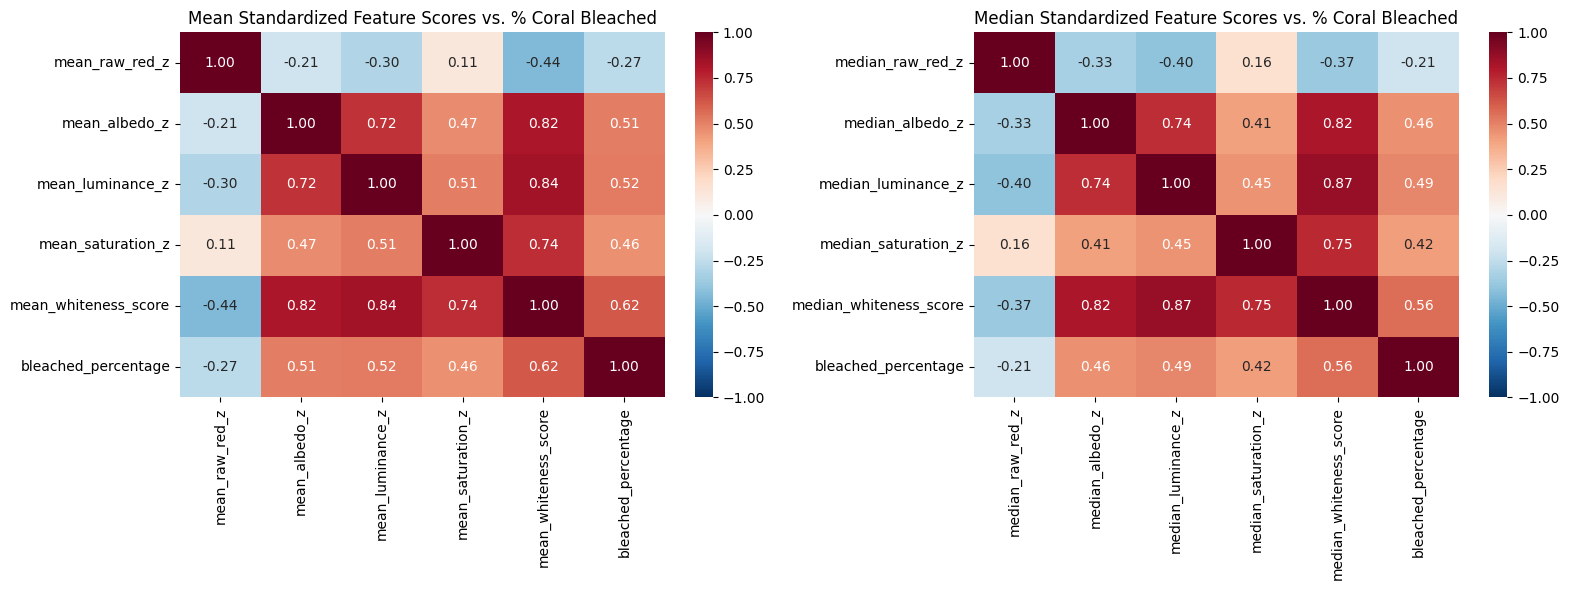

In [135]:
# Select relevant columns and compute correlation matrix for mean and median.
mean_features = df_standardized_color_features[[
    'mean_raw_red_z',
    'mean_albedo_z',
    'mean_luminance_z',
    'mean_saturation_z',
    'bleached_percentage'
]]
corr_mean = mean_features.corr()

median_features = df_standardized_color_features[[
    'median_raw_red_z',
    'median_albedo_z',
    'median_luminance_z',
    'median_saturation_z',
    'bleached_percentage'
]]
corr_median = median_features.corr()


# Calculate mean correlations, regression weights, and whiteness score
r_xy_mean = np.array([corr_mean.iloc[0,4], corr_mean.iloc[1,4], corr_mean.iloc[2,4], corr_mean.iloc[3,4]])  # correlation between mean values and bleaching percentage
R_xx_mean = np.array([                                                                                      # Feature-feature correlations
    [corr_mean.iloc[0,0], corr_mean.iloc[0,1], corr_mean.iloc[0,2], corr_mean.iloc[0,3]],
    [corr_mean.iloc[1,0], corr_mean.iloc[1,1], corr_mean.iloc[1,2], corr_mean.iloc[1,3]],
    [corr_mean.iloc[2,0], corr_mean.iloc[2,1], corr_mean.iloc[2,2], corr_mean.iloc[2,3]],
    [corr_mean.iloc[3,0], corr_mean.iloc[3,1], corr_mean.iloc[3,2], corr_mean.iloc[3,3]],
])

beta_mean  = inv(R_xx_mean) @ r_xy_mean   # (raw-red, albedo, luminance, saturation)

df_standardized_color_features["mean_whiteness_score"] = (
    beta_mean[0] * df_standardized_color_features["mean_raw_red_z"]
    + beta_mean[1] * df_standardized_color_features["mean_albedo_z"]
    + beta_mean[2] * df_standardized_color_features["mean_luminance_z"]
    + beta_mean[3] * df_standardized_color_features["mean_saturation_z"]
)


# Calculate median correlations, regression weights, and whiteness score
r_xy_median = np.array([corr_median.iloc[0,4], corr_median.iloc[1,4], corr_median.iloc[2,4], corr_median.iloc[3,4]])  # correlation between median values and bleaching percentage
R_xx_median = np.array([                                                                                              # Feature-feature correlations
    [corr_median.iloc[0,0], corr_median.iloc[0,1], corr_median.iloc[0,2], corr_median.iloc[0,3]],
    [corr_median.iloc[1,0], corr_median.iloc[1,1], corr_median.iloc[1,2], corr_median.iloc[1,3]],
    [corr_median.iloc[2,0], corr_median.iloc[2,1], corr_median.iloc[2,2], corr_median.iloc[2,3]],
    [corr_median.iloc[3,0], corr_median.iloc[3,1], corr_median.iloc[3,2], corr_median.iloc[3,3]],
])

beta_median  = inv(R_xx_median) @ r_xy_median   # (raw-red, albedo, luminance, saturation)

df_standardized_color_features["median_whiteness_score"] = (
    beta_median[0] * df_standardized_color_features["median_raw_red_z"]
    + beta_median[1] * df_standardized_color_features["median_albedo_z"]
    + beta_median[2] * df_standardized_color_features["median_luminance_z"]
    + beta_median[3] * df_standardized_color_features["median_saturation_z"]
)


# Save values to dataframe
cols = list(df_standardized_color_features.columns)
for new_col in ["median_whiteness_score", "mean_whiteness_score"]:
    cols = [c for c in cols if c != new_col] + [new_col]
df_standardized_color_features = df_standardized_color_features[cols]
df_standardized_color_features.to_csv("csv_folder/whiteness_scores_added.csv", index=False)


# Mean whiteness score 
corr_features_mean = [
    "mean_raw_red_z", "mean_albedo_z", "mean_luminance_z", "mean_saturation_z",
    "mean_whiteness_score", "bleached_percentage"
]
corr_matrix_mean = df_standardized_color_features[corr_features_mean].corr()


# Median whiteness score
corr_features_median = [
    "median_raw_red_z", "median_albedo_z", "median_luminance_z", "median_saturation_z",
    "median_whiteness_score", "bleached_percentage"
]
corr_matrix_median = df_standardized_color_features[corr_features_median].corr()


# Plot the results
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(
    corr_matrix_mean.round(2),
    annot=True,
    cmap='RdBu_r',
    center=0,
    vmin=-1,
    vmax=1,
    fmt=".2f",
    ax=axes[0]
)
axes[0].set_title("Mean Standardized Feature Scores vs. % Coral Bleached", fontsize=12)

sns.heatmap(
    corr_matrix_median.round(2),
    annot=True,
    cmap='RdBu_r',
    center=0,
    vmin=-1,
    vmax=1,
    fmt=".2f",
    ax=axes[1]
)
axes[1].set_title("Median Standardized Feature Scores vs. % Coral Bleached", fontsize=12)

plt.tight_layout()
plt.show()


### Section 3.2 Texture scores

The local binary pattern, laplacian, GLCM correlation, and bleaching percentage are calculated.  
LBP, LPN, and GLCM are standardized.  
The results are saved to a csv file.

100%|██████████| 601/601 [11:50<00:00,  1.18s/it]


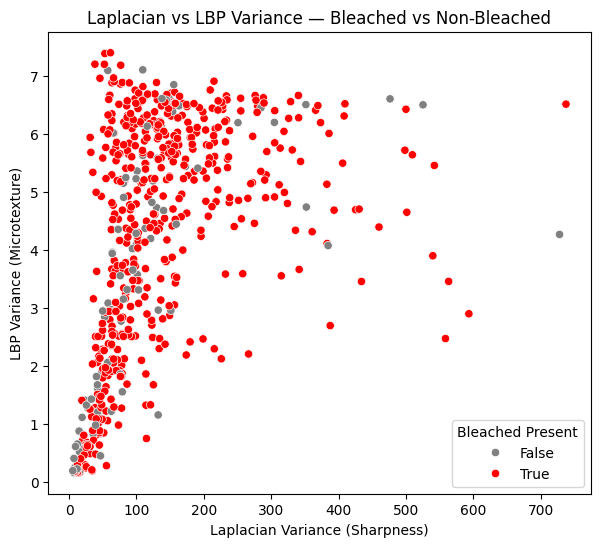

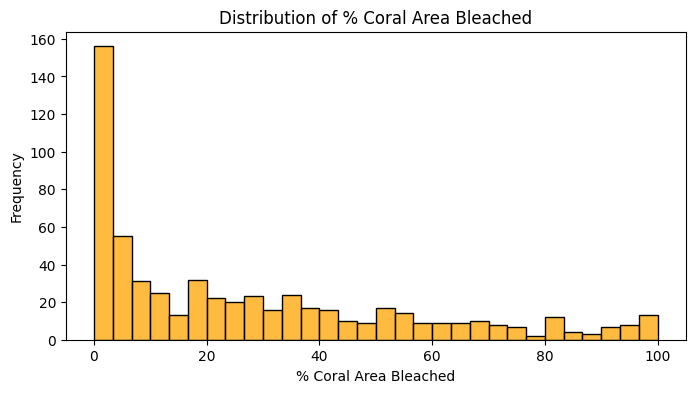

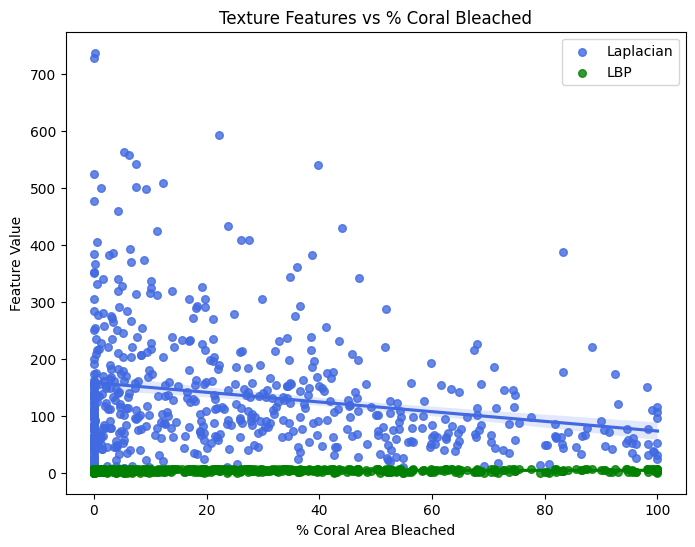

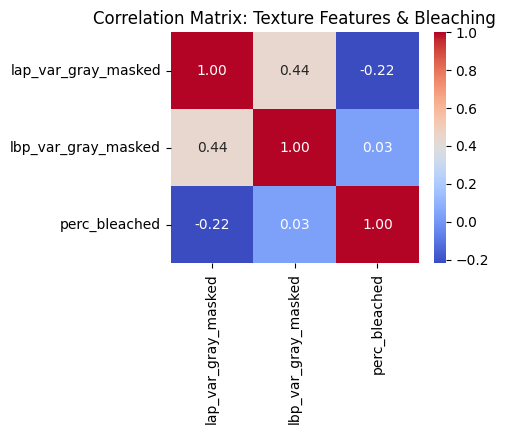

In [120]:
# Define texture features
def compute_lbp(img_gray):
    lbp = local_binary_pattern(img_gray, P=8, R=1, method='uniform')
    return np.var(lbp)

def compute_laplacian(img_gray):
    lap = cv2.Laplacian(img_gray, cv2.CV_64F)
    return lap.var()

def compute_glcm_features(gray_masked):
    gray = cv2.normalize(gray_masked, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    glcm = graycomatrix(gray, distances=[1, 2],
                        angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                        levels=256, symmetric=True, normed=True)
    return glcm

records = []
for _, row in tqdm(df_bleaching.iterrows(), total=len(df_bleaching)):
    # Define the image and mask, and create grayscale image
    bgr_img = cv2.imread(row["image_path"], cv2.IMREAD_COLOR)
    gray_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2GRAY)
    bleached_mask = cv2.imread(row["bleached_coral_path"], cv2.IMREAD_GRAYSCALE)
    coral_mask = cv2.imread(row["mask_coral_path"], cv2.IMREAD_GRAYSCALE)
    gray_masked = cv2.bitwise_and(gray_img, gray_img, mask=coral_mask)

    # Compute lap, lbp, glcm features, and percentage bleached.
    lap_var = compute_laplacian(gray_masked)
    lbp_var = compute_lbp(gray_masked)
    glcm = compute_glcm_features(gray_masked)
    glcm_correlation = graycoprops(glcm, "correlation").mean()
    
    total_coral = np.sum(coral_mask > 0)
    perc_bleached = (np.sum(bleached_mask > 0) / total_coral * 100.0) if total_coral > 0 else 0
    has_bleached = perc_bleached > 0

    records.append({
        "image_stem": row["stem"],
        "lap_var_gray_masked": lap_var,
        "lbp_var_gray_masked": lbp_var,
        "glcm_correlation": glcm_correlation,
        "perc_bleached": perc_bleached,
        "has_bleached": has_bleached, 
    })

df_texture_features = pd.DataFrame(records)

# Standardize the features
scaler = StandardScaler()
features_to_scale = ["lap_var_gray_masked", "lbp_var_gray_masked", "glcm_correlation"]

scaled_values = scaler.fit_transform(df_texture_features[features_to_scale])
scaled_df = pd.DataFrame(
    scaled_values,
    columns=[f"{c}_std" for c in features_to_scale]
)

# Create a single DataFrame, and save it
df_standardized_texture_features = pd.concat([df_texture_features.reset_index(drop=True), scaled_df], axis=1)



# ================================================================
# VISUALIZATIONS
# ================================================================
if len(df_texture_features) > 0:
    # 1️⃣ Scatter: Laplacian vs LBP
    plt.figure(figsize=(7,6))
    sns.scatterplot(data=df_texture_features,
                    x="lap_var_gray_masked",
                    y="lbp_var_gray_masked",
                    hue="has_bleached",
                    palette={True: "red", False: "gray"})
    plt.title("Laplacian vs LBP Variance — Bleached vs Non-Bleached")
    plt.xlabel("Laplacian Variance (Sharpness)")
    plt.ylabel("LBP Variance (Microtexture)")
    plt.legend(title="Bleached Present")
    plt.show()

    # 2️⃣ Histogram: Bleached coverage
    plt.figure(figsize=(8,4))
    sns.histplot(df_texture_features["perc_bleached"], bins=30, color="orange")
    plt.title("Distribution of % Coral Area Bleached")
    plt.xlabel("% Coral Area Bleached")
    plt.ylabel("Frequency")
    plt.show()

    # 3️⃣ Regression: % Bleaching vs Features
    plt.figure(figsize=(8,6))
    sns.regplot(data=df_texture_features, x="perc_bleached", y="lap_var_gray_masked",
                color="royalblue", label="Laplacian", scatter_kws={"s":30})
    sns.regplot(data=df_texture_features, x="perc_bleached", y="lbp_var_gray_masked",
                color="green", label="LBP", scatter_kws={"s":30})
    plt.title("Texture Features vs % Coral Bleached")
    plt.xlabel("% Coral Area Bleached")
    plt.ylabel("Feature Value")
    plt.legend()
    plt.show()

    # 4️⃣ Correlation heatmap
    corr = df_texture_features[["lap_var_gray_masked", "lbp_var_gray_masked", "perc_bleached"]].corr()
    plt.figure(figsize=(4,3))
    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Matrix: Texture Features & Bleaching")
    plt.show()


Compute the correlations between the texture features and themselves + percent bleached.  
We use this to get the standardized regression weights, which we then use to create a texture score.  

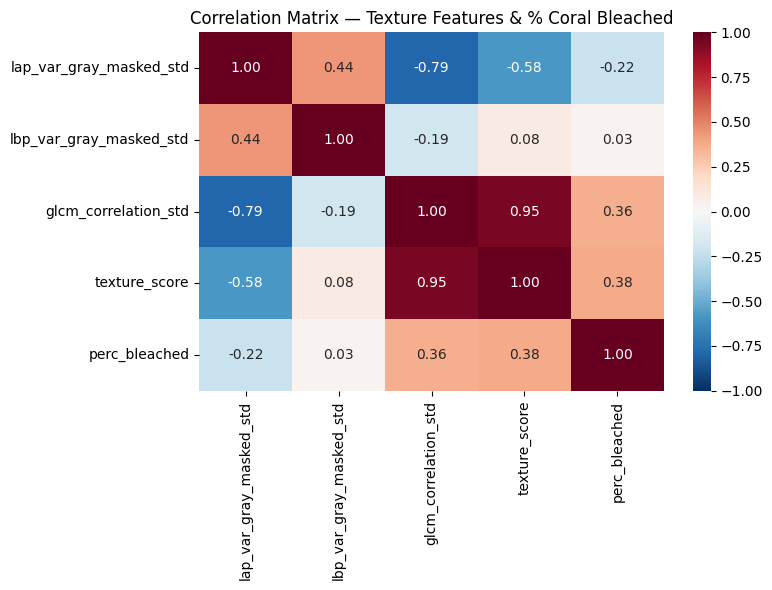

In [138]:
# Select relevant columns
corr_features = df_standardized_texture_features[[
    'lap_var_gray_masked_std',
    'lbp_var_gray_masked_std',
    'glcm_correlation_std',
    'perc_bleached'
]]

# Create correlation matrix and save relevant values
corr_matrix_features = corr_features.corr()
r_xy = np.array([corr_matrix_features.iloc[0,3], corr_matrix_features.iloc[1,3], corr_matrix_features.iloc[2,3]])   # Correlations with bleaching
R_xx = np.array([                                                                                                   # Feature-feature correlations
    [corr_matrix_features.iloc[0,0],  corr_matrix_features.iloc[0,1], corr_matrix_features.iloc[0,2]],
    [corr_matrix_features.iloc[1,0],  corr_matrix_features.iloc[1,1], corr_matrix_features.iloc[1,2]],
    [corr_matrix_features.iloc[2,0],  corr_matrix_features.iloc[2,1], corr_matrix_features.iloc[2,2]],
])

# Standardized regression weights (lap, lbp, glcm)
beta = inv(R_xx) @ r_xy

# Calculate the texture score
df_standardized_texture_features["texture_score"] = (
    beta[0] * df_standardized_texture_features["lap_var_gray_masked_std"]
    + beta[1] * df_standardized_texture_features["lbp_var_gray_masked_std"]
    + beta[2] * df_standardized_texture_features["glcm_correlation_std"]
)
# Add texture score to dataframe, and save it
cols = list(df_standardized_texture_features.columns)
cols = [c for c in cols if c != "texture_score"] + ["texture_score"]
df_standardized_texture_features = df_standardized_texture_features[cols]
df_standardized_texture_features.to_csv("csv_folder/bleaching_texture_with_score.csv", index=False)

# Compute correlations
corr_features = [
    "lap_var_gray_masked_std",
    "lbp_var_gray_masked_std",
    "glcm_correlation_std",
    "texture_score",
    "perc_bleached",
]

df_corr = df_standardized_texture_features[corr_features]
corr_matrix = df_corr.corr()


# plot correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix.round(2),
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",
    vmin=-1,
    vmax=1,
    center=0,
)
plt.title("Correlation Matrix — Texture Features & % Coral Bleached", fontsize=12)
plt.tight_layout()
plt.savefig("visualisations/texture_correlation_heatmap.png", dpi=300)
plt.show()

# Section 4: Severity score

First, a merged DataFrame is created with the texture score, mean and median whiteness score, and the bleached percentage.  
The correlation between texture and whiteness are computed, as well as the correlation between texture, whiteness and percentage bleached.  
&nbsp;&nbsp;&nbsp;&nbsp;Do note that now we only consider the median whiteness score.  
  
We use this matrix to compute the regression weights, which will be used to compute a severity score.  
Finally, the severity score is added to the last correlation matrix.  

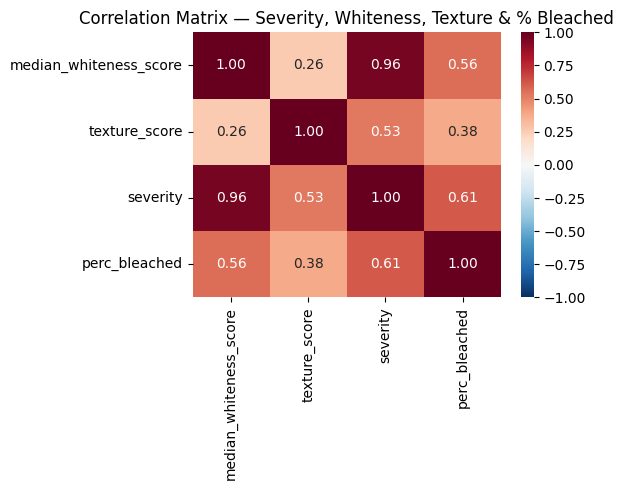

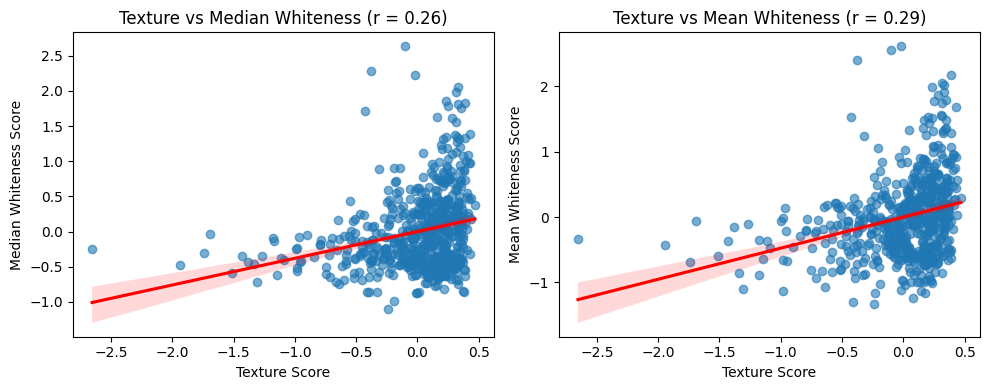

In [15]:
# Merge the texture and whiteness dataframes
df_merged = pd.merge(
    df_standardized_texture_features[["image_stem", "texture_score", "perc_bleached"]],
    df_standardized_color_features[["image_stem", "median_whiteness_score", "mean_whiteness_score"]],
    on="image_stem",
    how="inner",
    validate="one_to_one",
)

# Compute correlations between texture and whiteness
corr_median = df_merged["texture_score"].corr(df_merged["median_whiteness_score"])
corr_mean   = df_merged["texture_score"].corr(df_merged["mean_whiteness_score"])


# Compute correlation between texture/whiteness and percentage bleached
corr_features = df_merged[[
    'median_whiteness_score',
    'texture_score',
    'perc_bleached'
]]
corr_matrix_features = corr_features.corr()
r_xy = np.array([corr_matrix_features.iloc[0,2], corr_matrix_features.iloc[1,2]])   # Correlations with bleaching
R_xx = np.array([                                                                   # Feature-feature correlations
    [corr_matrix_features.iloc[0,0],  corr_matrix_features.iloc[0,1]],
    [corr_matrix_features.iloc[1,0],  corr_matrix_features.iloc[1,1]],
])

# Define regression weights, and severity column.
beta = inv(R_xx) @ r_xy # (median_whiteness_score, texture_score)

df_merged["severity"] = (
    beta[0] * df_merged["median_whiteness_score"]
    + beta[1] * df_merged["texture_score"]
)


# Save final DataFrame
df_merged.to_csv("csv_folder/merged_with_severity.csv", index=False)

# Compute correlation matrix with new severity score.
corr_features = ["median_whiteness_score", "texture_score", "severity", "perc_bleached"]
corr_matrix = df_merged[corr_features].corr()


# The correlation matrix is plotted
plt.figure(figsize=(6, 5))
sns.heatmap(
    corr_matrix.round(2),
    annot=True,
    cmap="RdBu_r",
    vmin=-1,
    vmax=1,
    center=0,
    fmt=".2f"
)
plt.title("Correlation Matrix — Severity, Whiteness, Texture & % Bleached", fontsize=12)
plt.tight_layout()
plt.savefig("visualisations/heatmap_severity_whiteness_texture.png", dpi=300)
plt.show()


# Scatter plot of texture vs whiteness is plotted
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.regplot(
    data=df_merged, x="texture_score", y="median_whiteness_score",
    scatter_kws={"alpha": 0.6}, line_kws={"color": "red"}
)
plt.title(f"Texture vs Median Whiteness (r = {corr_median:.2f})")
plt.xlabel("Texture Score")
plt.ylabel("Median Whiteness Score")

plt.subplot(1, 2, 2)
sns.regplot(
    data=df_merged, x="texture_score", y="mean_whiteness_score",
    scatter_kws={"alpha": 0.6}, line_kws={"color": "red"}
)
plt.title(f"Texture vs Mean Whiteness (r = {corr_mean:.2f})")
plt.xlabel("Texture Score")
plt.ylabel("Mean Whiteness Score")

plt.tight_layout()

plt.show()
